##  Импорты

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Кластеризация

Кластеризация  — задача группировки множества объектов на подмножества (кластеры) таким образом, чтобы объекты из одного кластера были более похожи друг на друга, чем на объекты из других кластеров по какому-либо критерию.

Кластеризация представляет собой алгоритм обучения без учителя

Какие есть алгоритмы кластеризации?

### K-means

Кластеризация K-средних представляет собой одну из самых простых реализаций, суть которой заключается в итеративной инициализации центроидов для каждого кластера на основе среднего арифметического расположенных в нём наблюдений, а также их переопределении путём минимизации суммарного квадратичного отклонения от центроидов кластеров.

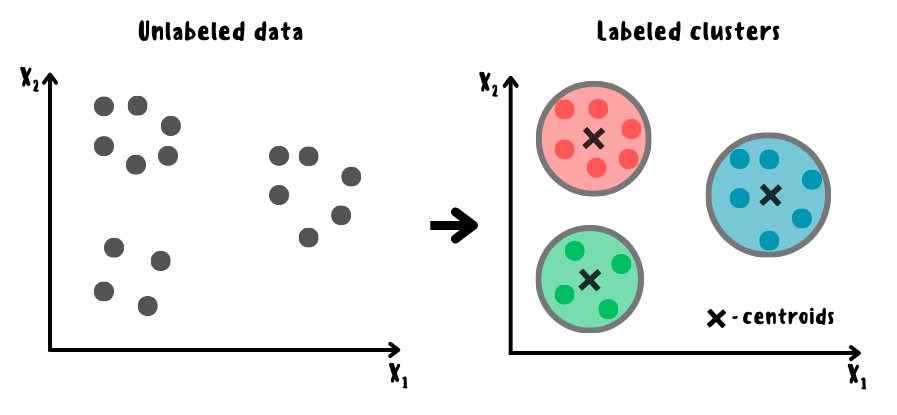

# Hierarchical clustering

Иерархическая кластеризация - это общее семейство алгоритмов кластеризации, которые создают вложенные кластеры путем их последовательного слияния или разделения. Эта иерархия кластеров представлена в виде дерева (или дендрограммы). Корень дерева - это уникальный кластер, в котором собраны все образцы, а листья - это кластеры только с одним образцом.

# Кластеризация - пример пайплайна на небольшом датасете

In [1]:
import pandas as pd

df = pd.read_parquet("hf://datasets/billingsmoore/text-clustering-example-data/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    925 non-null    object
 1   topic   925 non-null    object
dtypes: object(2)
memory usage: 14.6+ KB


In [3]:
df.shape

(925, 2)

## Этап 1. Проведем предобработку

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(925, 4)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')

# Инициализируем инструменты
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации и специальных символов
    text = re.sub(r'[^\w\s]', ' ', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    # Токенизация
    tokens = word_tokenize(text)

    # Фильтрация токенов:
    filtered_tokens = []
    for token in tokens:
        # короткие слова
        if (len(token) > 2 and
            token not in stop_words and
            not re.match(r'^[a-z]{1,2}$', token)):
            filtered_tokens.append(token)

    # Лемматизация
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized_tokens)

# Применяем улучшенную предобработку
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Проверяем результаты
print("До предобработки:")
print(df['text'].iloc[0][:300])
print("\nПосле предобработки:")
print(df['cleaned_text'].iloc[0])

До предобработки:
The pickup truck was loaded with heavy construction materials.

После предобработки:
pickup truck loaded heavy construction material


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


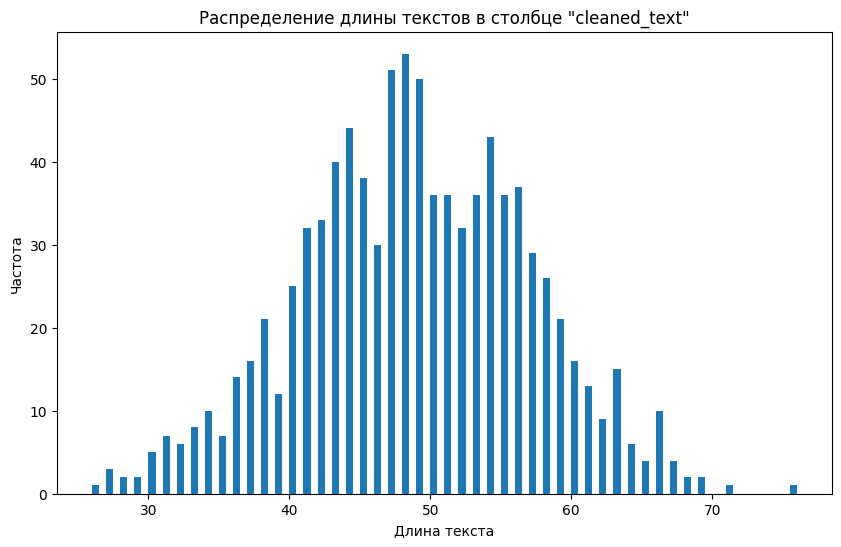

In [ ]:
# cмотрим на распределение длин текстов теперь
df['cleaned_text_len'] = df['cleaned_text'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(df['cleaned_text_len'], bins=100)
plt.title('Распределение длины текстов в столбце "cleaned_text"')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

In [ ]:
# фильтруем хвосты
df_filtered = df[(df['cleaned_text_len'] >= 10) & (df['cleaned_text_len'] < 70)].copy()

In [ ]:
df_filtered.shape

(923, 6)

## Этап 2. Векторизация предобработанных тексто

In [ ]:
# cоздаем векторизатор TF-IDF с ограничением на количество признаков
# можно экспериментировать с значением max_features для поиска оптимального размера словаря
tfidf_vectorizer_filtered = TfidfVectorizer(max_features=2000)

# обучаем и преобразуем тексты из отфильтрованного датафрейма
tfidf_matrix_filtered = tfidf_vectorizer_filtered.fit_transform(df_filtered['cleaned_text'])


print("Словарь TF-IDF (ограниченный):")
print(tfidf_vectorizer_filtered.get_feature_names_out())
print("\nРазмер словаря TF-IDF:", len(tfidf_vectorizer_filtered.get_feature_names_out()))
print("\nМатрица TF-IDF (плотный формат, первые 5 строк):")
# Выводим только первые 5 строк для наглядности, так как матрица может быть большой
display(tfidf_matrix_filtered[:5].toarray())

Словарь TF-IDF (ограниченный):
['abyssinian' 'accelerated' 'access' ... 'young' 'zest' 'zone']

Размер словаря TF-IDF: 2000

Матрица TF-IDF (плотный формат, первые 5 строк):


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.47320569, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Этап 3. А сколько у нас кластеров?

В задачах кластеризации, таких как наша (кластеризация текстов описаний фильмов), мы **редко заранее знаем истинное количество кластеров**. Это связано с тем, что кластеры не являются предопределенными категориями с четкими границами, а скорее представляют собой группы объектов, которые по каким-то признакам (в нашем случае, по содержанию текста) похожи друг на друга больше, чем на объекты из других групп.

В отличие от задач классификации, где у нас есть размеченные данные с известными классами, в кластеризации мы работаем с неразмеченными данными. Цель кластеризации как раз и состоит в том, чтобы **найти естественные группы** в данных.

### Как определить оптимальное количество кластеров?

Существует несколько подходов и метрик для определения "оптимального" количества кластеров, хотя идеального метода, подходящего для всех случаев, не существует. Некоторые из популярных методов включают:

1.  **Метод локтя (Elbow Method):** Этот метод основан на графике зависимости искажения (суммы квадратов расстояний объектов до центров их кластеров) от количества кластеров. Оптимальное количество кластеров часто находится в точке "изгиба" или "локтя" на графике, где уменьшение искажения начинает замедляться.
2.  **Silhouette Score:** Как мы уже рассчитывали, эта метрика оценивает, насколько хорошо каждый объект соответствует своему кластеру по сравнению с другими кластерами. Мы можем рассчитать Silhouette Score для разного количества кластеров и выбрать то количество, которое дает наибольшее значение (близкое к 1).
3.  **DBSCAN:** Некоторые алгоритмы кластеризации, такие как DBSCAN, не требуют предварительного указания количества кластеров. Вместо этого они определяют кластеры на основе плотности распределения объектов.

Выбор метода зависит от типа данных, алгоритма кластеризации и целей анализа. Часто приходится экспериментировать с разными методами и количеством кластеров, а также интерпретировать результаты, чтобы найти наиболее осмысленное разбиение на кластеры.

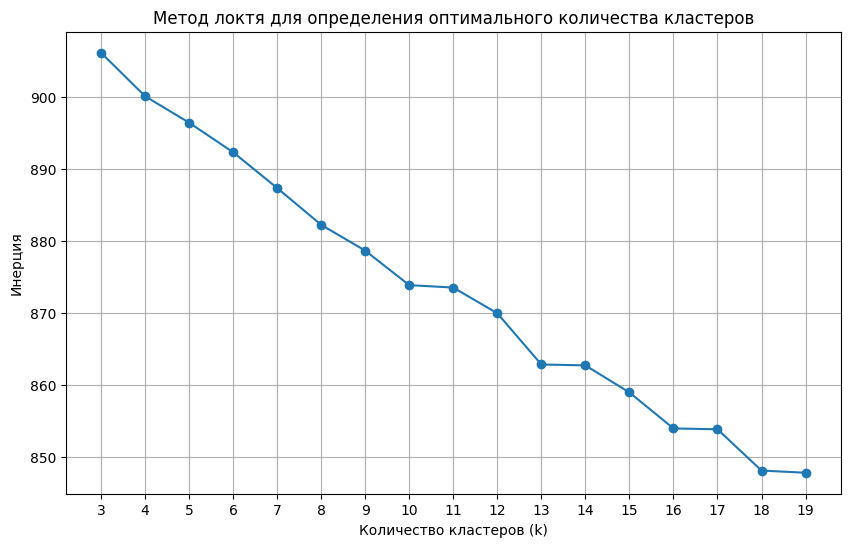

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Определим диапазон количества кластеров для проверки
k_range = range(3, 20) # Можно изменить диапазон при необходимости

# Создадим пустой список для хранения значений инерции
inertia = []

# Обучим модель KMeans для каждого количества кластеров и сохраним инерцию
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix_filtered)
    inertia.append(kmeans.inertia_)

# Построим график метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Этап 4. Кластеризация

In [ ]:
# возьмем количество кластеров на основе графика выше
n_clusters = 10

# Создаем модель KMeans
# random_state для воспроизводимости результатов
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Обучаем модель на TF-IDF матрице
kmeans.fit(tfidf_matrix_filtered)

# Получаем метки кластеров для каждого документа
cluster_labels = kmeans.labels_

# Добавляем метки кластеров в исходный датафрейм
df_filtered['cluster'] = cluster_labels

# Выводим количество документов в каждом кластере
print("Распределение документов по кластерам:")
print(df_filtered['cluster'].value_counts())

Распределение документов по кластерам:
cluster
3    452
4     80
1     60
5     60
2     57
0     51
8     47
7     45
6     38
9     33
Name: count, dtype: int64


In [ ]:
# Функция для определения топ-слов для каждого кластера
def get_top_n_words(cluster_centers, feature_names, n_top_words):
    top_words = {}
    for i in range(len(cluster_centers)):
        # Получаем индексы признаков, отсортированные по убыванию веса в центре кластера
        top_feature_indices = cluster_centers[i].argsort()[:-n_top_words - 1:-1]
        # Получаем сами слова по их индексам
        top_features = [feature_names[j] for j in top_feature_indices]
        top_words[f"Кластер {i}"] = top_features
    return top_words

# Получаем центры кластеров из обученной модели KMeans
cluster_centers = kmeans.cluster_centers_

# Получаем список признаков (слов) из векторизатора TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Определяем количество топ-слов, которое хотим увидеть
n_top_words = 10

# Получаем топ-слова для каждого кластера
top_words_per_cluster = get_top_n_words(cluster_centers, feature_names, n_top_words)

# Выводим топ-слова для каждого кластера
for cluster, words in top_words_per_cluster.items():
    print(f"{cluster}: {', '.join(words)}")

Кластер 0: quarter, largest, race, improve, purification, emissions, pursuit, continuously, christianity, dancer
Кластер 1: relieve, pointer, got, look, improve, handle, apple, keen, lingered, purposes
Кластер 2: altar, progress, distinct, depletion, leaving, liberation, brewed, dessert, each, leash
Кластер 3: especially, cheered, attempt, diversity, decide, fleet, blender, lingered, constant, chandelier
Кластер 4: indoors, leaped, fireplace, friendly, judgment, monk, race, diversity, fabric, eaves
Кластер 5: group, emphasize, peels, braising, improve, modify, handed, agility, delighting, experts
Кластер 6: claiming, crunchy, refreshing, helped, recently, hollow, navigating, reaction, attracted, go
Кластер 7: adopted, discomfort, barbecues, preserves, created, quacked, given, break, processor, industry
Кластер 8: believers, ratatouille, napping, advanced, improve, maintaining, beak, has, global, bite
Кластер 9: audibled, dished, batter, knife, phrases, preventing, covered, intense, fli

## Этап 5. оценка качества

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(tfidf_matrix_filtered, cluster_labels)
silhouette_avg

np.float64(0.01603221949874882)

## Этап 6. Визуализация

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


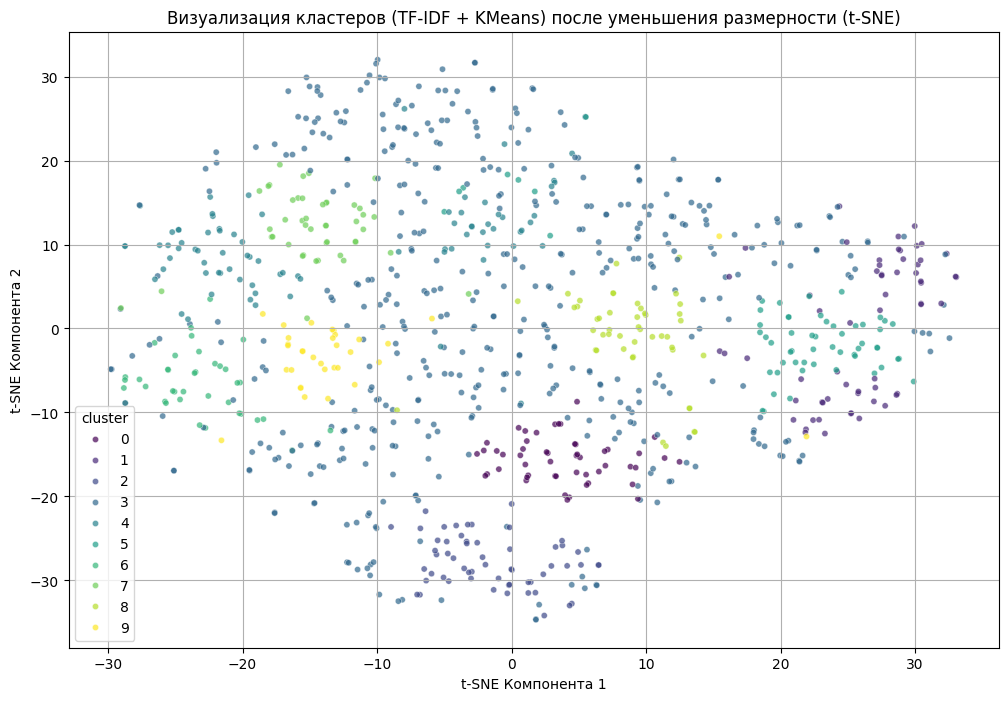

In [ ]:
from sklearn.manifold import TSNE

tsne_tfidf = TSNE(
    n_components=2,
    random_state=42,
    n_iter=300,
    perplexity=30,
    init='random',
    learning_rate='auto',
    n_iter_without_progress=100
)

# Преобразуем разреженную матрицу в плотную
tfidf_dense = tfidf_matrix_filtered.toarray()

# Применяем t-SNE
tfidf_tsne = tsne_tfidf.fit_transform(tfidf_dense)

# Создаем DataFrame с уменьшенными данными и метками кластеров
tsne_tfidf_df = pd.DataFrame(tfidf_tsne, columns=['tsne_component_1', 'tsne_component_2'])
tsne_tfidf_df['cluster'] = cluster_labels

# Визуализируем кластеры
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_component_1',
    y='tsne_component_2',
    hue='cluster',
    data=tsne_tfidf_df,
    palette='viridis',
    legend='full',
    alpha=0.7,
    s=20
)
plt.title('Визуализация кластеров (TF-IDF + KMeans) после уменьшения размерности (t-SNE)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

# Пробуем другие модели и другую векторизацию

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 81.0 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np

# Токенизируем тексты для Word2Vec
# Word2Vec ожидает список списков слов
tokenized_text = df_filtered['cleaned_text'].apply(lambda x: x.split())

word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=5, workers=4)

# Функция для усреднения векторов слов в документе
def document_vector(word2vec_model, doc):
    # Удаляем слова, которых нет в словаре Word2Vec
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if not doc:
        # Если после удаления не осталось слов, возвращаем вектор из нулей
        return np.zeros(word2vec_model.vector_size)
    # Усредняем векторы оставшихся слов
    return np.mean(word2vec_model.wv[doc], axis=0)

# Получаем векторные представления для каждого документа
word2vec_vectors = np.array([document_vector(word2vec_model, doc) for doc in tokenized_text])

# Выводим размерность полученных векторов
print("Размерность векторов Word2Vec:", word2vec_vectors.shape)

Размерность векторов Word2Vec: (923, 100)


In [ ]:
n_clusters_w2v = 12

kmeans_w2v = KMeans(n_clusters=n_clusters_w2v, random_state=42, n_init=10)

# Обучаем модель на Word2Vec векторах
kmeans_w2v.fit(word2vec_vectors)

# Получаем метки кластеров для каждого документа
cluster_labels_w2v = kmeans_w2v.labels_
df_filtered['cluster_w2v'] = cluster_labels_w2v

print("Распределение документов по кластерам (Word2Vec + KMeans):")
print(df_filtered['cluster_w2v'].value_counts())

Распределение документов по кластерам (Word2Vec + KMeans):
cluster_w2v
9     322
11    152
4     128
5      52
2      46
10     41
1      41
0      33
3      28
6      28
8      26
7      26
Name: count, dtype: int64


In [ ]:
silhouette_avg_w2v = silhouette_score(word2vec_vectors, cluster_labels_w2v)
silhouette_avg_w2v

np.float64(0.06867856176959265)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


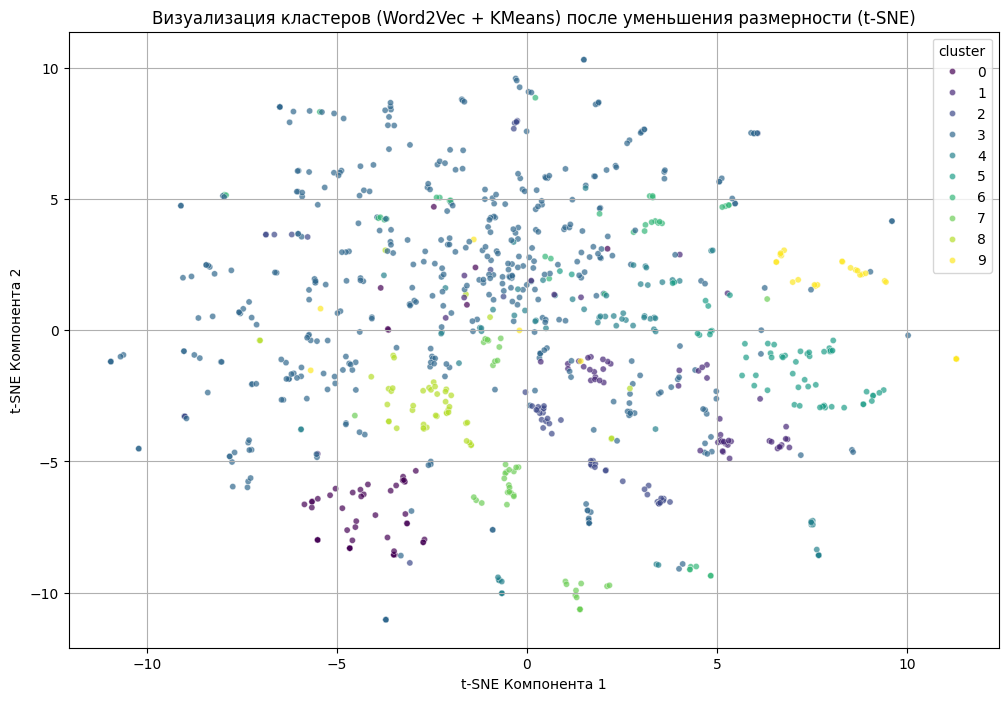

In [ ]:
tsne_w2v = TSNE(
    n_components=2,
    random_state=42,
    n_iter=300,
    perplexity=30,
    init='random',
    learning_rate='auto',
    n_iter_without_progress=100
)

word2vec_tsne = tsne_w2v.fit_transform(word2vec_vectors)

tsne_w2v_df = pd.DataFrame(word2vec_tsne, columns=['tsne_component_1',
                                                   'tsne_component_2'])
tsne_w2v_df['cluster'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_component_1',
    y='tsne_component_2',
    hue='cluster',
    data=tsne_w2v_df,
    palette='viridis',
    legend='full',
    alpha=0.7,
    s=20
)
plt.title('Визуализация кластеров (Word2Vec + KMeans) после уменьшения размерности (t-SNE)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

# Вспомним, что мы знаем исходные классы

In [ ]:
df_filtered.head(2)

,text,topic,text_length,cluster,cleaned_text,cleaned_text_len,cluster_w2v
0,The pickup truck was loaded with heavy constru...,cars and trucks,62,0,pickup truck loaded heavy construction material,47,5
1,The sports car accelerated down the highway at...,cars and trucks,67,3,sport car accelerated highway incredible speed,46,8


In [ ]:
df_filtered['topic'].unique()

array(['cars and trucks', 'cats and dogs', 'condos and houses',
       'ducks and songbirds', 'apples and oranges',
       'religion and spirituality', 'yoga and meditation',
       'football and basketball', 'plants and gardening',
       'cooking and cuisine'], dtype=object)

In [ ]:
df_filtered['topic'].value_counts()

,count
topic,
cars and trucks,97
cats and dogs,93
cooking and cuisine,93
yoga and meditation,93
religion and spirituality,92
apples and oranges,92
plants and gardening,92
condos and houses,91
ducks and songbirds,90


Как видим, кластеризация вышла не очень. Скорее всего, нужно использовать более продвинутые эмбеддинги, а также более полный датасет.

# Кластеризация реальных текстов


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV

In [ ]:
! wget https://github.com/sharuvaruu/text-clustering-topic-modelling/raw/refs/heads/main/data.xlsx

--2025-11-14 17:53:08--  https://github.com/sharuvaruu/text-clustering-topic-modelling/raw/refs/heads/main/data.xlsx
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sharuvaruu/text-clustering-topic-modelling/refs/heads/main/data.xlsx [following]
--2025-11-14 17:53:08--  https://raw.githubusercontent.com/sharuvaruu/text-clustering-topic-modelling/refs/heads/main/data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83776 (82K) [application/octet-stream]
Saving to: ‘data.xlsx.1’

data.xlsx.1         100%[===================>]  81.81K  --.-KB/s    in 0.006s  

2025-11-14 17:53:08 (14.1 MB/s) - 

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

print(nltk.download('punkt', quiet=True))
print(nltk.download('wordnet', quiet=True))
print(nltk.download('stopwords', quiet=True))
print(nltk.download('averaged_perceptron_tagger', quiet=True))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


True
True
True
True


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!ls

data.xlsx  data.xlsx.1	sample_data


In [ ]:
data = pd.read_excel('data.xlsx')
data.head(2)

,Idea,Topic
0,The idea is to create a ticketing support syst...,NaN
1,Level 1 - Integrate Machine Learning Algorit...,NaN


In [ ]:
ideas = data['Idea']

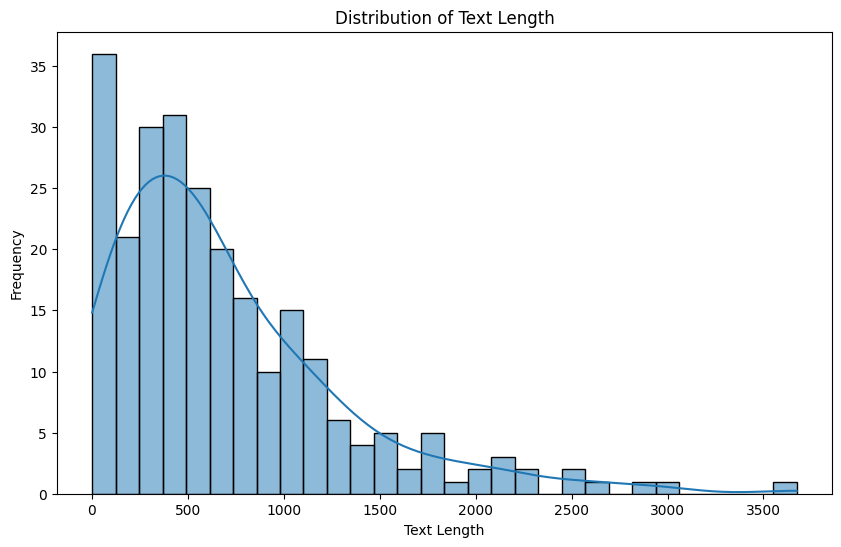

In [ ]:
idea_length = ideas.str.len()
plt.figure(figsize=(10, 6))
sns.histplot(idea_length, bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

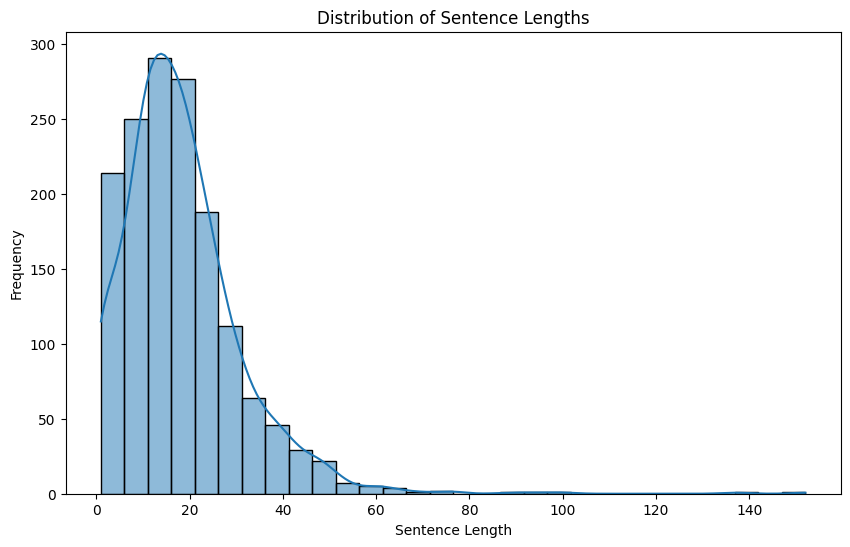

In [ ]:
# разбиваем на предложения
sentences = []
for idea in ideas:
    if isinstance(idea, str):
        for sent in idea.split('.'):
            if sent.strip():
                sentences.append(sent.strip())
    else:
        pass

# Считаем длины текстов
sentence_lengths = [len(sent.split()) for sent in sentences]

# График распределения
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

# NER
ner_data = []
for idea in ideas:
    if isinstance(idea, str):
        doc = nlp(idea)
        ner_data.append([(ent.text, ent.label_) for ent in doc.ents])
    else:
        ner_data.append([])

In [ ]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

def preprocess_text(text):
    text = str(text).lower()  # Преобразование текста в нижний регистр
    text = re.sub(r'\W', ' ', text)  # Удаление небуквенных символов
    tokens = word_tokenize(text)  # Токенизация текста

    # Рассмотрите возможность сохранения более распространенных слов, таких как "user" и "data"
    stop_words = set(stopwords.words('english')) - {'user', 'data'}
    custom_stop_words = {'include', 'custom', 'stop', 'words', 'list', 'specific', 'dataset', 'filter', 'irrelevant'}
    stop_words.update(custom_stop_words)

    # Частеречная разметка с расширенными категориями
    tagged_tokens = nltk.pos_tag(tokens)

    # Фильтрация токенов по частям речи (сохраняем существительные, глаголы, прилагательные, наречия)
    filtered_tokens = [token for token, pos in tagged_tokens
                        if pos.startswith('N') or pos.startswith('V') or pos.startswith('J') or pos.startswith('R')]

    # Лемматизация (или стемминг, если предпочтительно)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# Применяем функцию предобработки
corpus = [preprocess_text(text) for text in ideas]

In [ ]:
from collections import Counter

word_counts = Counter(" ".join(corpus).split())

In [ ]:
# Топ-10 слов
print("Top 10 Most Frequent Words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

Top 10 Most Frequent Words:
be: 395
is: 338
user: 178
customer: 175
data: 157
system: 151
product: 138
based: 134
are: 133
ticket: 129


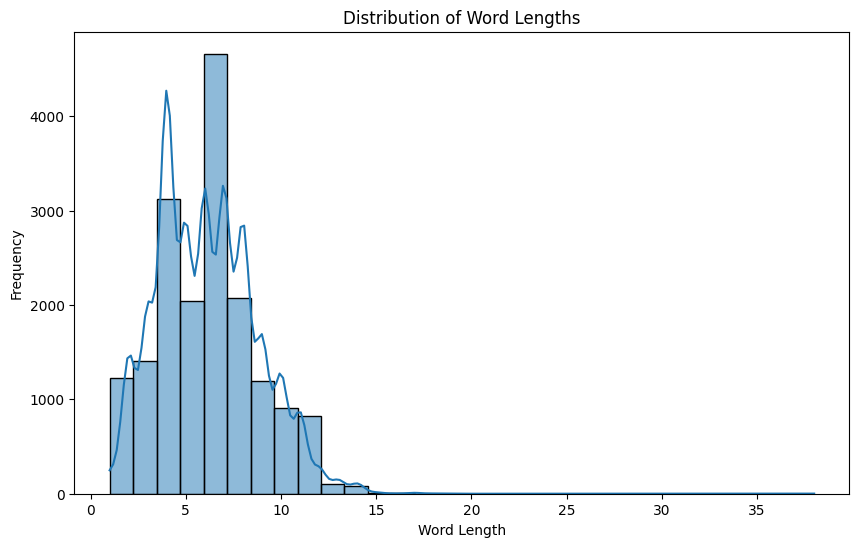

In [ ]:
# Считаем длины слоов
word_lengths = [len(word) for idea in corpus for word in idea.split()]

# График распределения
plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=30, kde=True)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

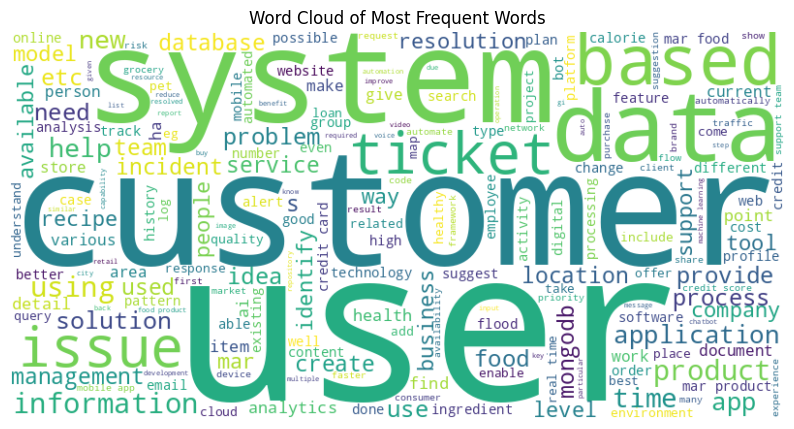

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(corpus))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, sublinear_tf=True, norm='l2')
tfidf_matrix = vectorizer.fit_transform(corpus)

In [ ]:
# уменьшаем размерность через NMF
nmf = NMF(n_components=2, random_state=42)
tfidf_nmf = nmf.fit_transform(tfidf_matrix)

In [ ]:
# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = hc.fit_predict(tfidf_nmf)

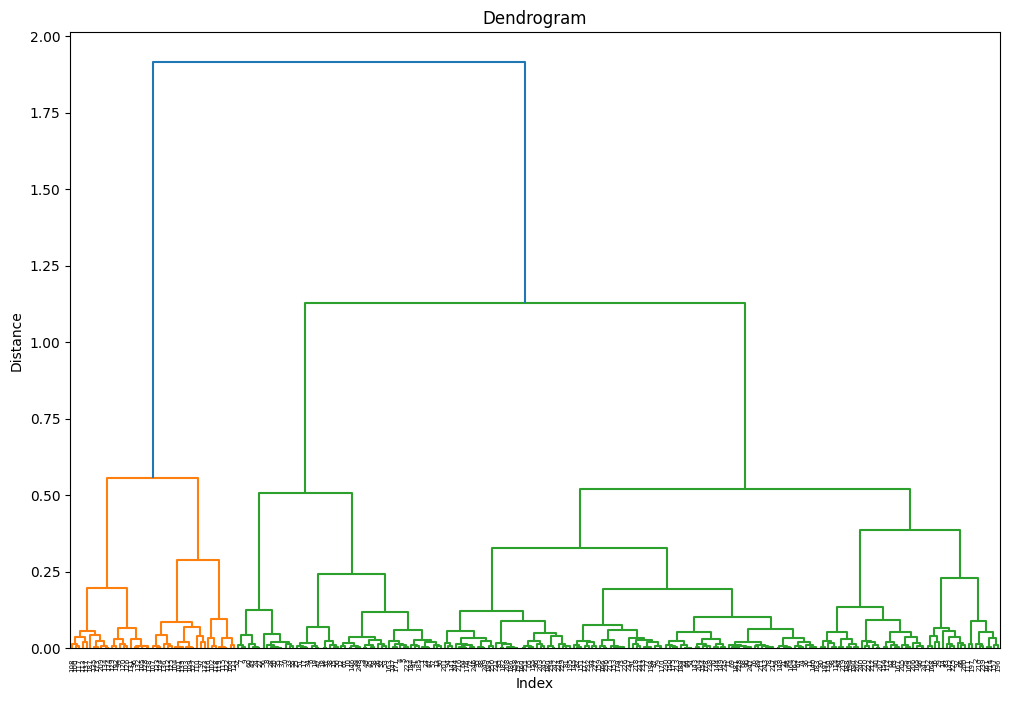

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)
nmf = NMF(n_components=2, random_state=42)
tfidf_nmf = nmf.fit_transform(tfidf_matrix)

hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = hc.fit_predict(tfidf_nmf)

linkage_matrix = linkage(tfidf_nmf, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='top')
plt.title("Dendrogram")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Анализ самых важных слов для каждого кластера с использованием скоров TF-IDF
top_words_per_cluster = {}
feature_names = vectorizer.get_feature_names_out()

for cluster_id in range(hc.n_clusters):
    top_words_per_cluster[cluster_id] = []
    cluster_tfidf = tfidf_matrix[clusters == cluster_id]  # Получение TF-IDF матрицы для текущего кластера
    cluster_tfidf_mean = np.array(cluster_tfidf.mean(axis=0)).squeeze()  # Вычисление средних значений TF-IDF для каждого признака
    top_feature_indices = np.argsort(cluster_tfidf_mean)[::-1][:10]  # Сортировка индексов признаков по убыванию средних значений TF-IDF и выбор топ-10

    for feature_idx in top_feature_indices:
        word = feature_names[feature_idx]  # Получение слова по индексу признака
        score = cluster_tfidf_mean[feature_idx]  # Получение соответствующей оценки TF-IDF
        top_words_per_cluster[cluster_id].append((word, score))  # Добавление слова и его оценки в список топовых слов кластера

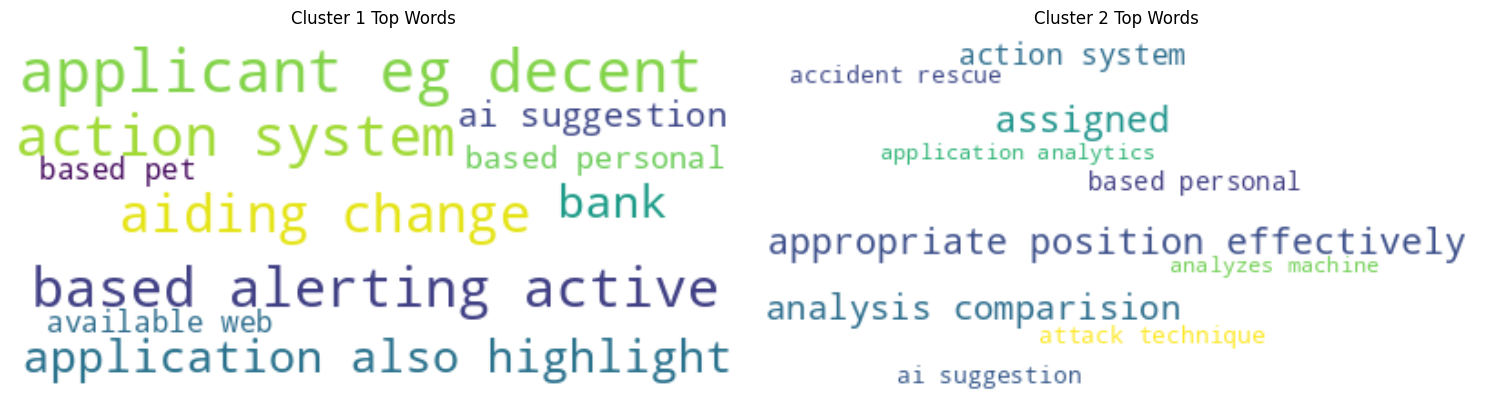

In [ ]:
# Построение облаков слов для топовых слов каждого кластера
def plot_word_clouds(top_words_per_cluster):
    num_clusters = len(top_words_per_cluster)

    # Создание подграфиков для каждого кластера
    fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5), squeeze=False)
    for cluster_id, top_words in top_words_per_cluster.items():
        # Преобразование списка топовых слов в словарь для входных данных WordCloud
        wordcloud_dict = {word: score for word, score in top_words}

        # Генерация облака слов для текущего кластера
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Построение облака слов в соответствующем подграфике
        axs[0, cluster_id].imshow(wordcloud, interpolation='bilinear')
        axs[0, cluster_id].set_title(f'Топовые слова кластера {cluster_id + 1}')
        axs[0, cluster_id].axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds(top_words_per_cluster)

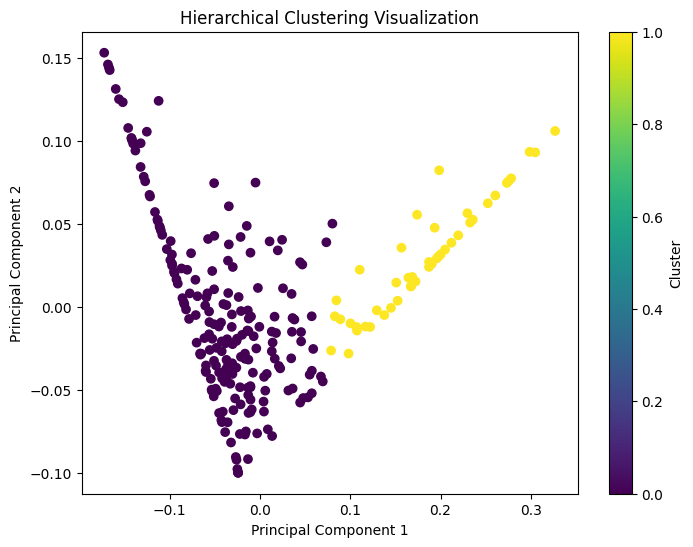

Number of Clusters: 2

Top Words per Cluster:
Cluster 1:
- applicant eg decent (0.0426)
- action system (0.0407)
- based alerting active (0.0377)
- aiding change (0.0355)
- application also highlight (0.0327)
- bank (0.0326)
- ai suggestion (0.0321)
- based personal (0.0252)
- available web (0.0236)
- based pet (0.0229)
Cluster 2:
- appropriate position effectively (0.1254)
- assigned (0.1226)
- analysis comparision (0.1138)
- action system (0.0788)
- based personal (0.0616)
- attack technique (0.0530)
- accident rescue (0.0490)
- ai suggestion (0.0488)
- analyzes machine (0.0414)
- application analytics (0.0410)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Визуализируем кластеры
plt.figure(figsize=(8, 6))
pca = PCA(n_components=2)
tfidf_nmf_pca = pca.fit_transform(tfidf_nmf)
plt.scatter(tfidf_nmf_pca[:, 0], tfidf_nmf_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

print(f"Number of Clusters: {hc.n_clusters}")

print("\nTop Words per Cluster:")
for cluster_id, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_id+1}:")
    for word, score in top_words:
        print(f"- {word} ({score:.4f})")